**Student: Dimitrios Tanoglidis**

# Non-Linear Regression

In [100]:
#Import stuff
import numpy as np 
import pandas as pd
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       
    #plt.rc('text', usetex=True)      
    plt.rc('font', size=fontsize)    
    plt.rc('xtick', direction='in')  
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) 

    return
plot_pretty()

**Let's read the data first**

In [101]:
df_train = pd.read_csv('gss_train.csv') #Train data
df_test = pd.read_csv('gss_test.csv') #Test data

df_train.head()

,age,attend,authoritarianism,black,born,childs,colath,colrac,colcom,colmil,...,social_connect,social_cons3,south,spend3,teensex,tolerance,tvhours,vetyears,wordsum,zodiac
0,21,Never,4,No,YES,0,NOT ALLOWED,NOT ALLOWED,FIRED,NOT ALLOWED,...,5,Mod,Nonsouth,Conserv,ALWAYS WRONG,10,3,NONE,5,ARIES
1,42,Never,4,No,YES,2,ALLOWED,NOT ALLOWED,NOT FIRED,ALLOWED,...,5,Liberal,Nonsouth,Mod,NOT WRONG AT ALL,13,3,NONE,6,ARIES
2,70,<Once/yr,1,Yes,YES,3,ALLOWED,NOT ALLOWED,NOT FIRED,ALLOWED,...,5,Liberal,Nonsouth,Conserv,ALWAYS WRONG,10,3,NONE,6,TAURUS
3,35,Sev times/yr,2,No,YES,2,ALLOWED,NOT ALLOWED,FIRED,NOT ALLOWED,...,10,Liberal,Nonsouth,Liberal,ALWAYS WRONG,11,3,NONE,6,SCORPIO
4,24,Sev times/yr,6,No,NO,3,NOT ALLOWED,NOT ALLOWED,FIRED,ALLOWED,...,4,Mod,Nonsouth,Conserv,ALMST ALWAYS WRG,7,2,NONE,4,SCORPIO


## Egalitarianism and Income

Let's get the `egalit_scale` (y value, dependent variable we want to predict) and `income06` (independent vairable, x-value).

In [102]:
# Get features - income 06
X_inc_train = df_train['income06'].values
X_inc_test = df_test['income06'].values
# Get responses
y_train = df_train['egalit_scale'].values
y_test = df_test['egalit_scale'].values

### Polynomial Regression
 
Let's start with polynomial regression. The first step is to find the polynomial degree that gives the minimum MSE. Let's check polynomial degrees 1-9.

In [103]:
from sklearn.model_selection import cross_val_score
deg = np.arange(1,9)    
MSE_polyn = np.zeros(8)

# First define the model - it will be a linear regression model for all cases
Lin_Reg = linear_model.LinearRegression(fit_intercept=True,normalize=True)
for i in range(1,9):
    
    # Construct a matrix with the polynomials of the income. 
    # This is known as the Vandermonde matrix
    X_train_mat = np.vander(X_inc_train, N=i+1, increasing=True)[:,1:]
    # Calculate the 10-fold cross validation score
    CV_score_loc = cross_val_score(Lin_Reg,X_train_mat,y_train, scoring='neg_mean_squared_error', cv=10)
    
    MSE_polyn[i-1] = np.mean(CV_score_loc)     

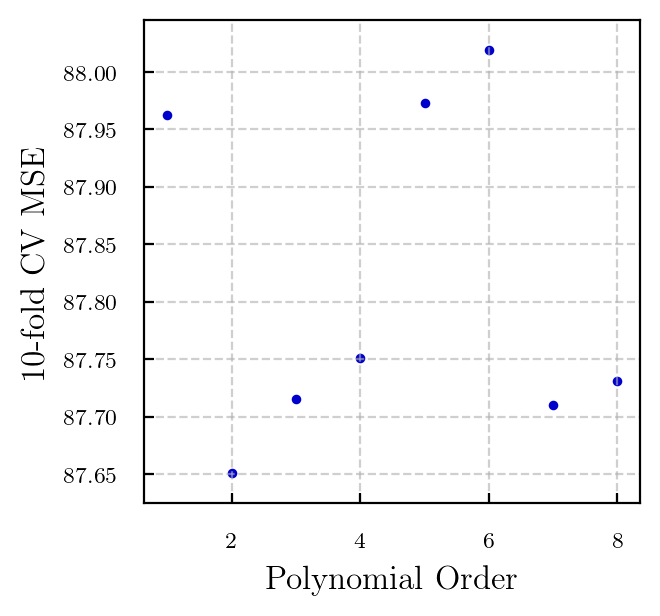

In [104]:
plt.figure(figsize=(3.2,3.2))
plt.scatter(deg,-MSE_polyn,s=6,color='mediumblue')
plt.xlabel('Polynomial Order', fontsize=12);plt.ylabel('10-fold CV MSE', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.show()

In [105]:
print(deg[MSE_polyn==np.max(MSE_polyn)])

[2]


The MSE from 10-fold CV is minimized for a degree $d=2$. Let's calculate the polynomial fit to the data. 

In [106]:
X_train_3 = np.vander(X_inc_train, N=3, increasing=True) # Training feature matrix - degree 3
X_test_3 = np.vander(X_inc_train, N=3, increasing=True) # Testing feature matrix - degree 3

# Fit the model
Lin_Reg.fit(X_train_3,y_train)
# get coefficients
print(Lin_Reg.coef_)
print(Lin_Reg.intercept_)

b_0 = Lin_Reg.intercept_
b_1 = (Lin_Reg.coef_)[1]
b_2 = (Lin_Reg.coef_)[2]

[ 0.          0.08355841 -0.01602243]
23.04877044890067


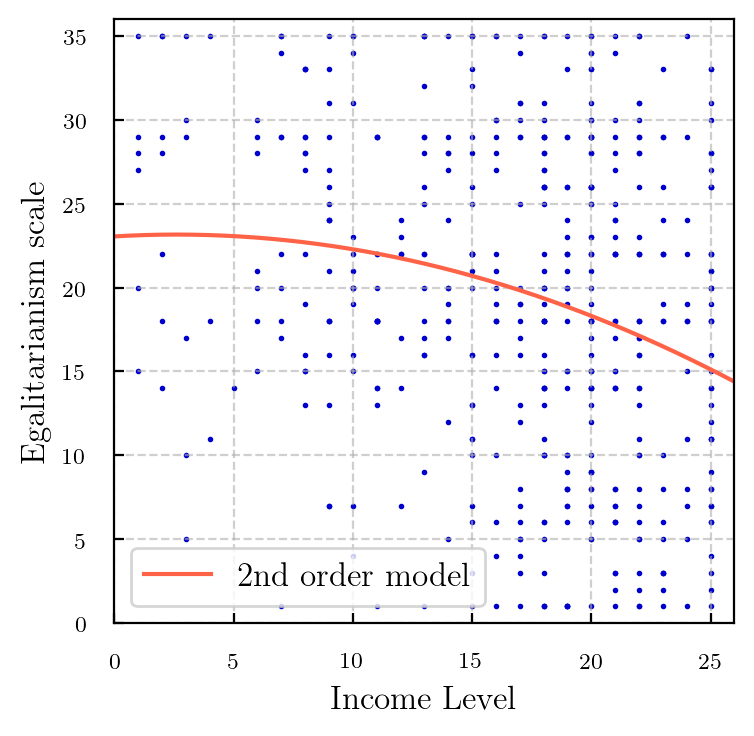

In [107]:
x_val = np.linspace(0,26,200)
y_val = b_0 + b_1*x_val + b_2*(x_val**2.0)#The model

plt.figure(figsize=(4.0,4.0))

plt.scatter(X_inc_test,y_test,c='mediumblue', s=1.0)
plt.plot(x_val,y_val, color='tomato', label='2nd order model')
plt.xlim(0,26);plt.ylim(0,36)
plt.legend(frameon=True, loc='lower left', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.xlabel('Income Level',fontsize=12);plt.ylabel('Egalitarianism scale',fontsize=12)
plt.show()

Now let's calculate and plot the average marginal effect. Since we have a second order polynomial:

\begin{equation}
\boxed{
\frac{\partial Y}{\partial X} = \beta_1 + 2\beta_2 X}
\end{equation}

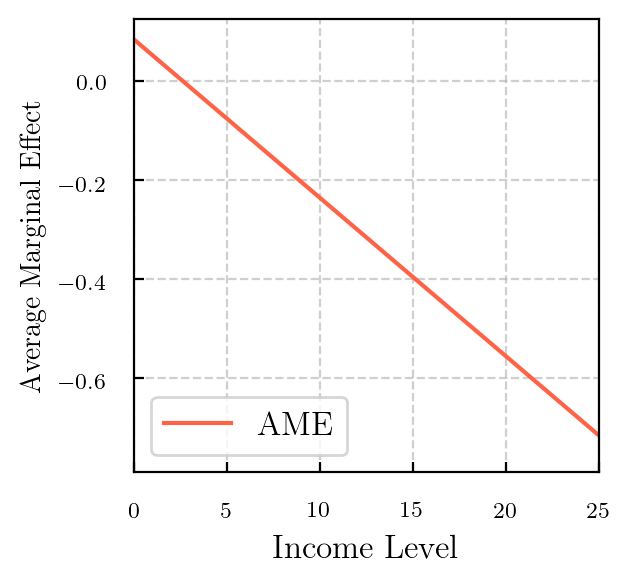

In [108]:
AME = b_1 +2.0*b_2*x_val

plt.figure(figsize=(3.0,3.0))

plt.plot(x_val,AME,color='tomato', label='AME')

plt.xlim(0,25)
plt.xlabel('Income Level',fontsize=12);plt.ylabel('Average Marginal Effect',fontsize=10)
plt.grid(ls='--', alpha=0.6)
plt.legend(frameon=True, loc='lower left', fontsize=12)
plt.show()

### Step Function

Here I will test 1-15 bins.

In [109]:
MSE_bins = np.zeros(15)

# First define the model - it will be a linear regression model for all cases
Lin_Reg = linear_model.LinearRegression(fit_intercept=True,normalize=True)

for i in range(1,16):
    n_bins = i # The number of bins to test
    # Split in number of bins n_bins
    x_train_bins = pd.cut(X_inc_train, n_bins)
    # Now get dummies
    bins_dummies = pd.get_dummies(x_train_bins)
    # calculate cross validation score
    CV_score_loc = cross_val_score(Lin_Reg,bins_dummies.values,y_train, scoring='neg_mean_squared_error', cv=10)
    
    MSE_bins[i-1] = np.mean(CV_score_loc)
    

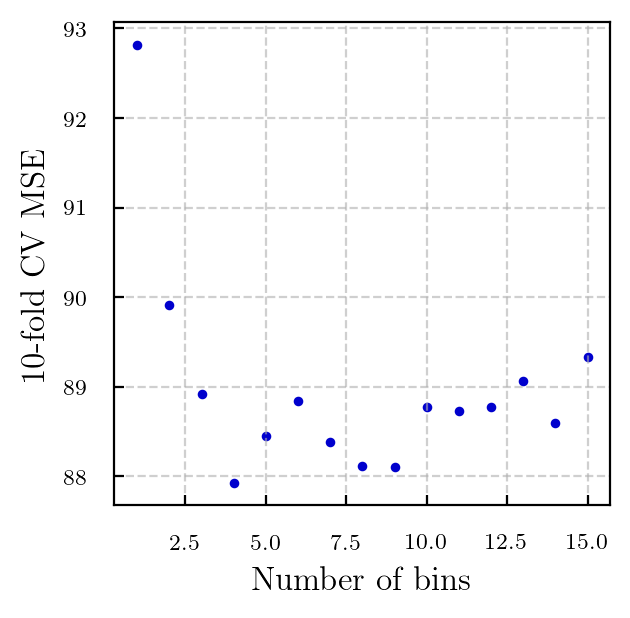

In [110]:
num_bins = np.arange(1,16)
plt.figure(figsize=(3.2,3.2))
plt.scatter(num_bins,-MSE_bins,s=6,color='mediumblue')
plt.xlabel('Number of bins', fontsize=12);plt.ylabel('10-fold CV MSE', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.show()

In [111]:
print(num_bins[MSE_bins==np.max(MSE_bins)])

[4]


The optimal number of bins are 4 (MSE is minimized).

In [112]:
# Split the train set in 4 bins
x_train_4bins = pd.cut(X_inc_train, 4)
# Get dummies
bins_dummies4bs = pd.get_dummies(x_train_4bins)
# Keep only values
bins_vals = bins_dummies4bs.values
# ========================================
# Split the test set in 4 bins
x_test_4bins = pd.cut(X_inc_test, 4)
# Get dummies
bins_dummies4bs_tst = pd.get_dummies(x_test_4bins)
# Keep only values
bins_vals_test = bins_dummies4bs_tst.values

# Fit a linear regression model 
Lin_Reg.fit(bins_vals,y_train)
# Predict
x_lin = np.linspace(0,26,300)
# Split the test set in 4 bins
x_lin_4bins = pd.cut(x_lin, 4)
# Get dummies
lin_dummies_4bs = pd.get_dummies(x_lin_4bins)
# Keep only values
lin_dummies_vals = lin_dummies_4bs.values

y_pred_lin = Lin_Reg.predict(lin_dummies_vals)

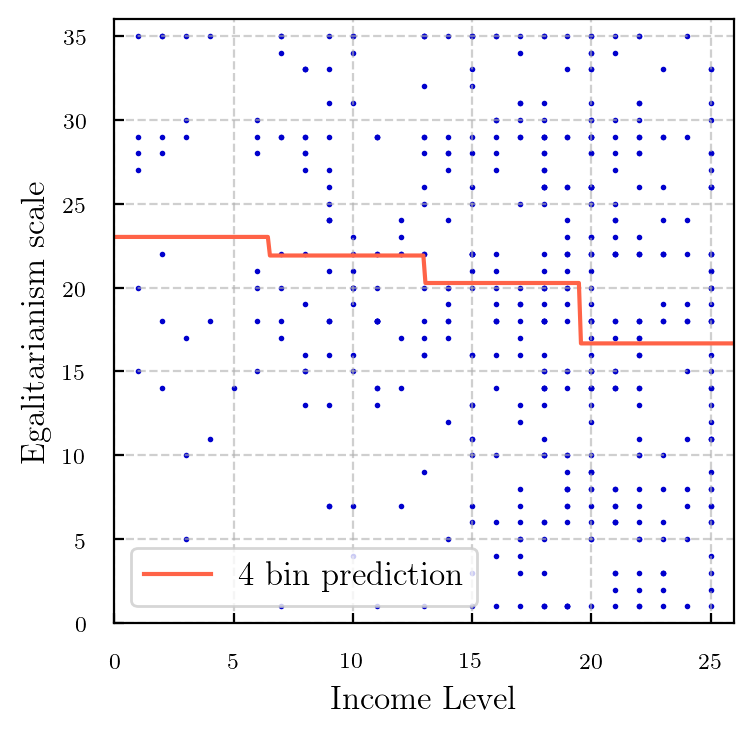

In [113]:
plt.figure(figsize=(4.0,4.0))

plt.scatter(X_inc_test,y_test,c='mediumblue', s=1.0)
plt.plot(x_lin,y_pred_lin, color='tomato', label='4 bin prediction')
plt.xlim(0,26);plt.ylim(0,36)
plt.legend(frameon=True, loc='lower left', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.xlabel('Income Level',fontsize=12);plt.ylabel('Egalitarianism scale',fontsize=12)
plt.show()

### Natural Regression Spline

In [114]:
from patsy import dmatrix
MSE_df = np.zeros(14)
#X_train = X_inc_train.astype(float).reshape(X_inc_train.size,1)

for i in range(3,17):
    df = i # The number of degrees of freedom
    transform_x_mat = dmatrix("cr(train,df)", {"train": X_inc_train, "df":df},return_type='matrix')
    # calculate cross validation score
    CV_score_loc = cross_val_score(Lin_Reg,transform_x_mat,y_train, scoring='neg_mean_squared_error', cv=10)
    
    MSE_df[i-3] = np.mean(CV_score_loc)


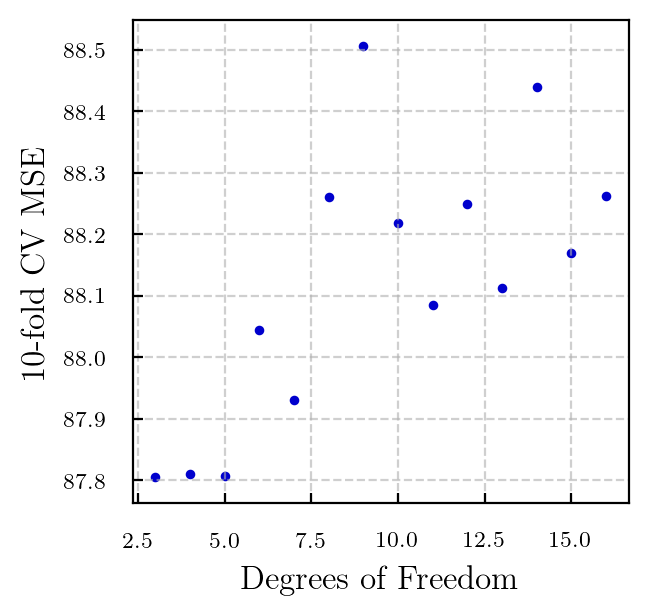

In [115]:
num_df = np.arange(3,17)
plt.figure(figsize=(3.2,3.2))
plt.scatter(num_df,-MSE_df,s=6,color='mediumblue')
plt.xlabel('Degrees of Freedom', fontsize=12);plt.ylabel('10-fold CV MSE', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.show()

In [116]:
print(num_df[MSE_df==np.max(MSE_df)])

[3]


The optimal number of degrees of freedom is 3.

In [117]:
# Fit a model with 3 degrees of freedom
transform_x_mat = dmatrix("cr(train,df)", {"train": X_inc_train, "df":3},return_type='matrix')
nat_reg = linear_model.LinearRegression(fit_intercept=True,normalize=True)
nat_reg.fit(transform_x_mat,y_train)
x_lin = np.linspace(0,26,300)
x_lin_trans = dmatrix("cr(train,df)", {"train": x_lin, "df":3},return_type='matrix')
# predict
y_predict = nat_reg.predict(x_lin_trans)

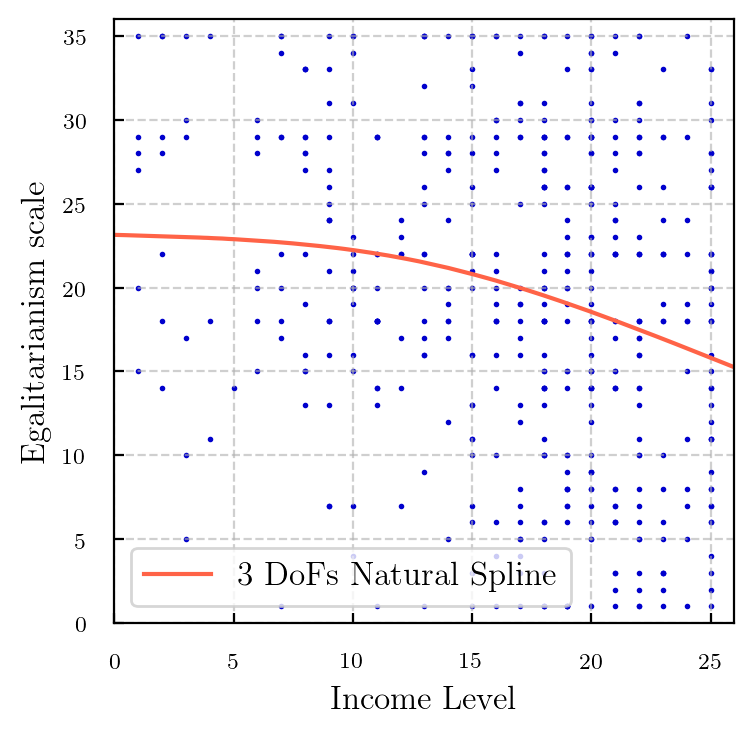

In [118]:
plt.figure(figsize=(4.0,4.0))

plt.scatter(X_inc_test,y_test,c='mediumblue', s=1.0)
plt.plot(x_lin,y_predict, color='tomato', label='3 DoFs Natural Spline')
plt.xlim(0,26);plt.ylim(0,36)
plt.legend(frameon=True, loc='lower left', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.xlabel('Income Level',fontsize=12);plt.ylabel('Egalitarianism scale',fontsize=12)
plt.savefig('Lala.pdf')
plt.show()

## Egalitarianism and Everything

Ok, **because I have no time** Here I will use the old csv (from the previous week) that have just numerical and no categorical values.

In [119]:
df_train = pd.read_csv('gss_train_old.csv') #Train data
df_test = pd.read_csv('gss_test_old.csv') #Test data

y_train = df_train['egalit_scale'].values
y_test = df_test['egalit_scale'].values

X_train = df_train.loc[:, df_train.columns != 'egalit_scale'].values
X_test = df_test.loc[:, df_test.columns != 'egalit_scale'].values

### Linear Regression

In [120]:
OLS = linear_model.LinearRegression(fit_intercept = True)
# Calculate 10-fold cross valuidation score on the test set
cv_score = cross_val_score(OLS,X_train,y_train, scoring='neg_mean_squared_error', cv=10)
# Fit on the model
OLS.fit(X_train,y_train)
y_pred_ols = OLS.predict(X_test)

print(np.mean(-cv_score))
# Calculate MSE Error on the test set
print(MSE(y_pred_ols,y_test))

62.35894714833688
63.213629623014995


The training MSE is $\sim 62.35$ and the test MSE is $\sim 63.2$.

Let's plot now

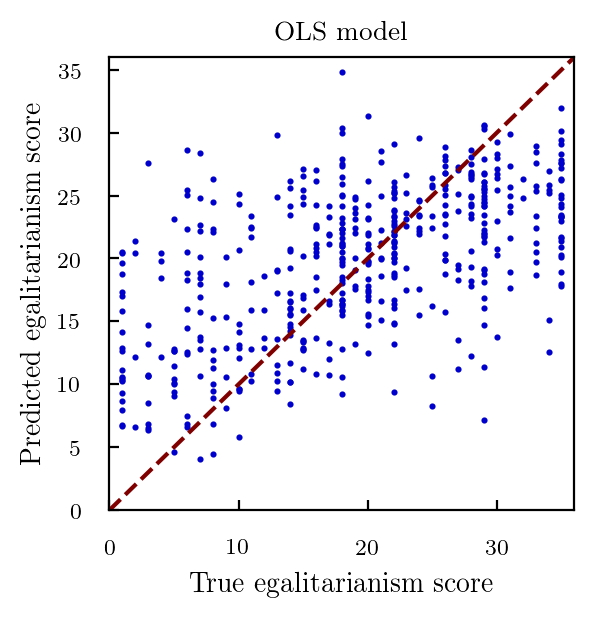

In [121]:
x_lin = np.linspace(0,36,200)
plt.figure(figsize=(3.0,3.0))

plt.scatter(y_test,y_pred_ols,color='mediumblue', s=1.5)
plt.plot(x_lin,x_lin,c='maroon',ls='--')

plt.xlabel('True egalitarianism score',fontsize=10)
plt.ylabel('Predicted egalitarianism score',fontsize=10)
plt.title('OLS model')
plt.xlim(0,36);plt.ylim(0,36)
plt.show()

In [122]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,100,1000],
             'l1_ratio': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
ElasticNet = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True)

grid = GridSearchCV(ElasticNet, param_grid,cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'alpha': 0.1, 'l1_ratio': 0.9}


In [123]:
ElasticNet = linear_model.ElasticNet(alpha=0.1,l1_ratio=0.9, fit_intercept=True)
ElasticNet.fit(X_train,y_train)
y_pred_Elastic = ElasticNet.predict(X_test)
# ==========================
MSE_Elastic = MSE(y_test,y_pred_Elastic)

cv_score_Elastic = cross_val_score(ElasticNet,X_train,y_train, scoring='neg_mean_squared_error', cv=10)
print(-np.mean(cv_score_Elastic))
print(MSE_Elastic)

59.38738651409231
62.73277839229572


Training set MSE $\sim 59.4$.

Testing set MSE $\sim 62.7$.

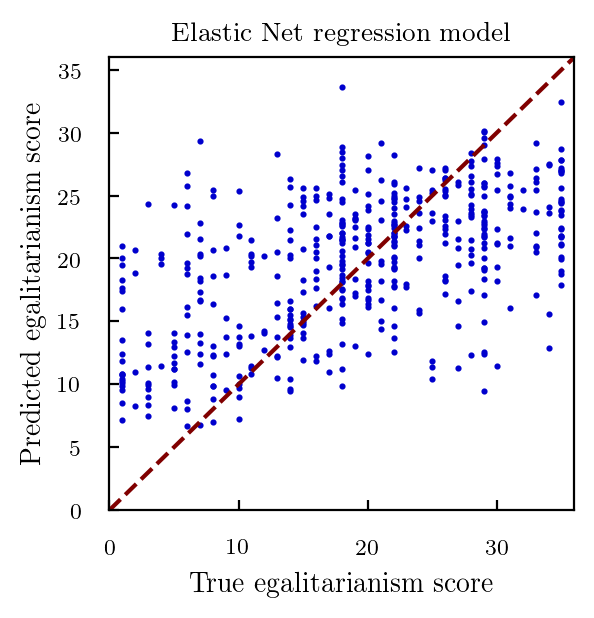

In [124]:
plt.figure(figsize=(3.0,3.0))

plt.scatter(y_test,y_pred_Elastic,color='mediumblue', s=1.5)
plt.plot(x_lin,x_lin,c='maroon',ls='--')

plt.xlabel('True egalitarianism score',fontsize=10)
plt.ylabel('Predicted egalitarianism score',fontsize=10)
plt.title('Elastic Net regression model')
plt.xlim(0,36);plt.ylim(0,36)
plt.show()

### Principal component Regression

In [125]:
from sklearn.decomposition import PCA
OLS = linear_model.LinearRegression(fit_intercept = True)
MSE_comp = np.zeros(50)

for i in range(1,51):
    n_com = i
    pca = PCA(n_components=i)
    X_loc = np.copy(X_train)
    X_new = pca.fit_transform(X_loc)
    
    
    CV_score_loc = cross_val_score(OLS,X_new,y_train, scoring='neg_mean_squared_error', cv=10)
    
    MSE_comp[i-1] = -np.mean(CV_score_loc)
   
    

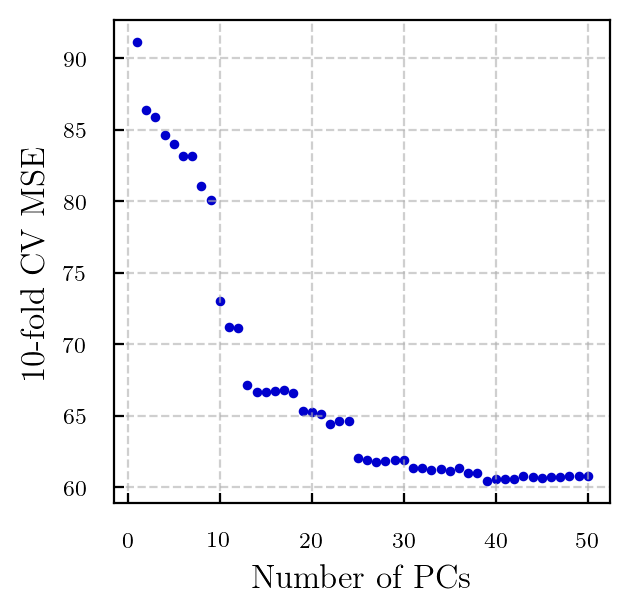

In [126]:
comps = np.arange(1,51)
plt.figure(figsize=(3.2,3.2))
plt.scatter(comps,MSE_comp,s=6,color='mediumblue')
plt.xlabel('Number of PCs', fontsize=12);plt.ylabel('10-fold CV MSE', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.show()

In [127]:
print(comps[MSE_comp==np.min(MSE_comp)])

[39]


The Mean Squared Error (MSE) is minimized for 40 Principal Components.

In [128]:
print(MSE_comp[comps==40])

[60.5912367]


In [129]:
pca = PCA(n_components=40)
X_loc = np.copy(X_train)
X_new = pca.fit_transform(X_loc)
X_new_test = pca.transform(X_test)
OLS.fit(X_new,y_train)
y_predict_PCs = OLS.predict(X_new_test)

MSE_PCA = MSE(y_test,y_predict_PCs)

print(MSE_PCA)

62.59443891063733


Train MSE $\sim 60.4$, test MSE $\sim 62.4$.

### Partial Least Squares regression

In [130]:
from sklearn.cross_decomposition import PLSRegression

In [131]:
MSE_PLSR = np.zeros(50)

for i in range(1,51):
    n_com = i
    PLSR_mod = PLSRegression(n_components=n_com)
    
    CV_score_loc = cross_val_score(PLSR_mod,X_train,y_train, scoring='neg_mean_squared_error', cv=10)
    
    MSE_PLSR[i-1] = -np.mean(CV_score_loc)

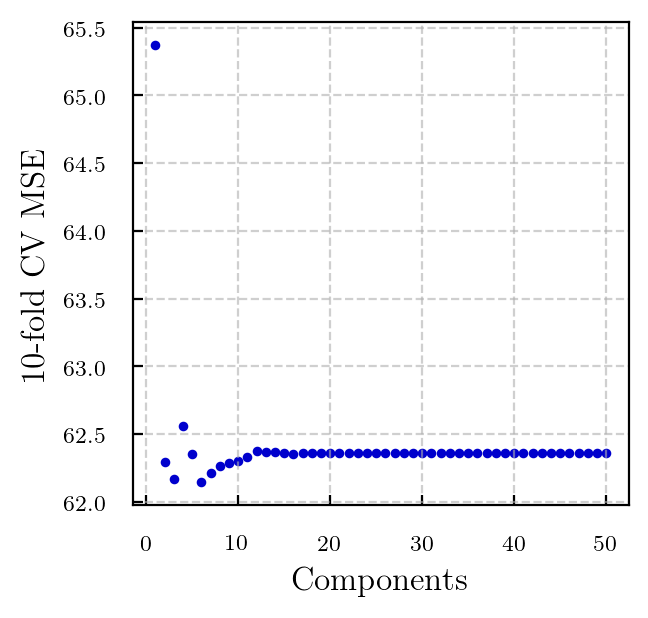

In [132]:
comps = np.arange(1,51)
plt.figure(figsize=(3.2,3.2))
plt.scatter(comps,MSE_PLSR,s=6,color='mediumblue')
plt.xlabel('Components', fontsize=12);plt.ylabel('10-fold CV MSE', fontsize=12)
plt.grid(ls='--', alpha=0.6)
plt.show()

In [133]:
print(comps[MSE_PLSR==np.min(MSE_PLSR)])

[6]


Mean Square Error (on the training set) is minimized for 6 componetns.

In [134]:
print(MSE_PLSR[comps==6])

[62.143776]


In [135]:
PLSR_mod = PLSRegression(n_components=6)
PLSR_mod.fit(X_train,y_train) # Fit model
y_predict_PLSR = PLSR_mod.predict(X_test) 

print(MSE(y_predict_PLSR,y_test))

63.245203158910044


MSE on the training set: $\sim 62.1$

MSE on the test set: $\sim 63.2$.

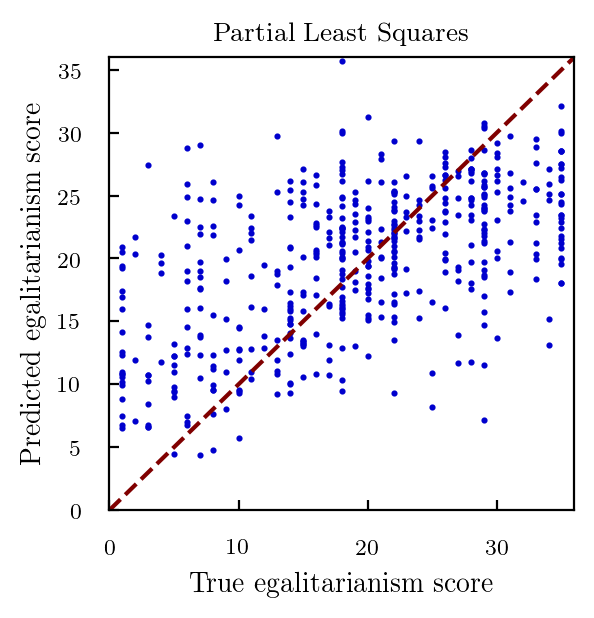

In [136]:
plt.figure(figsize=(3.0,3.0))

plt.scatter(y_test,y_predict_PLSR,color='mediumblue', s=1.5)
plt.plot(x_lin,x_lin,c='maroon',ls='--')

plt.xlabel('True egalitarianism score',fontsize=10)
plt.ylabel('Predicted egalitarianism score',fontsize=10)
plt.title('Partial Least Squares')
plt.xlim(0,36);plt.ylim(0,36)
plt.show()

## Feature Importances